In [76]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy.stats import linregress
from astropy import units as u
from astropy.constants import M_jup, M_earth

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

import string
import seaborn as sns

In [77]:
df = pd.read_csv(r'data/target_list_GLSfitted.csv')
df = df[~df["name_inner"].isin(["TOI-2015b", "Kepler-307b"])].reset_index(drop=True)
df.head()

,KOI_inner,KOI_outer,name_inner,name_outer,T0_inner,T0_inner_err,T0_outer,T0_outer_err,P_inner,P_inner_err,...,Pttv_outer_err,Attv_outer,Attv_outer_err,bic0_outer,bic1_outer,delta_bic_outer,fap_outer,f_searched_outer,TTV_strength_outer,scatter_outer
0,137.01,137.02,Kepler-18c,Kepler-18d,2.454961e+06,0.000502,2.455704e+06,0.000260,7.641562,5.700000e-07,...,0.472211,0.002859,NaN,1568.838740,695.276533,873.562208,1.237263e-27,5000.0,no_TTV,1.846272
1,248.01,248.02,Kepler-49b,Kepler-49c,2.454967e+06,0.001562,2.454970e+06,0.003099,7.203853,1.730000e-06,...,1.296243,0.013972,NaN,582.297603,337.441149,244.856454,5.230233e-13,5000.0,no_TTV,1.385000
2,277.02,277.01,Kepler-36b,Kepler-36c,2.454961e+06,0.027837,2.454956e+06,0.013792,13.849118,3.056000e-05,...,1.248697,0.080939,NaN,30764.833358,4529.031425,26235.801933,6.278113e-30,5000.0,strong,20.262500
3,775.02,775.01,Kepler-52b,Kepler-52c,2.454970e+06,0.002139,2.454973e+06,0.003392,7.877426,2.480000e-06,...,0.066685,0.007896,NaN,241.705229,215.543144,26.162084,6.239823e-01,5000.0,no_TTV,0.935000
4,834.01,834.05,Kepler-238e,Kepler-238f,2.454981e+06,0.000948,2.455011e+06,0.015041,23.653676,1.060000e-06,...,0.374995,0.017681,NaN,28.385813,26.998204,1.387608,3.722314e-01,5000.0,no_TTV,0.500000


In [78]:
# Create some empty columns
df2 = df.copy()
df2[['Pttv_deviation_inner', 'Pttv_deviation_outer']] = (
    df2[['Pttv_inner', 'Pttv_outer']].div(df2['expected_Pttv'], axis=0)
)
final_mass_cols = ['pl_mass_calc_inner', 'pl_mass_calc_inner_err', 'pl_mass_calc_outer', 'pl_mass_calc_outer_err']
df2[final_mass_cols] = np.nan
df2.head()

,KOI_inner,KOI_outer,name_inner,name_outer,T0_inner,T0_inner_err,T0_outer,T0_outer_err,P_inner,P_inner_err,...,fap_outer,f_searched_outer,TTV_strength_outer,scatter_outer,Pttv_deviation_inner,Pttv_deviation_outer,pl_mass_calc_inner,pl_mass_calc_inner_err,pl_mass_calc_outer,pl_mass_calc_outer_err
0,137.01,137.02,Kepler-18c,Kepler-18d,2.454961e+06,0.000502,2.455704e+06,0.000260,7.641562,5.700000e-07,...,1.237263e-27,5000.0,no_TTV,1.846272,0.999625,0.992131,NaN,NaN,NaN,NaN
1,248.01,248.02,Kepler-49b,Kepler-49c,2.454967e+06,0.001562,2.454970e+06,0.003099,7.203853,1.730000e-06,...,5.230233e-13,5000.0,no_TTV,1.385000,0.985731,1.024704,NaN,NaN,NaN,NaN
2,277.02,277.01,Kepler-36b,Kepler-36c,2.454961e+06,0.027837,2.454956e+06,0.013792,13.849118,3.056000e-05,...,6.278113e-30,5000.0,strong,20.262500,0.879268,0.898195,NaN,NaN,NaN,NaN
3,775.02,775.01,Kepler-52b,Kepler-52c,2.454970e+06,0.002139,2.454973e+06,0.003392,7.877426,2.480000e-06,...,6.239823e-01,5000.0,no_TTV,0.935000,1.005866,0.511835,NaN,NaN,NaN,NaN
4,834.01,834.05,Kepler-238e,Kepler-238f,2.454981e+06,0.000948,2.455011e+06,0.015041,23.653676,1.060000e-06,...,3.722314e-01,5000.0,no_TTV,0.500000,1.014461,1.151038,NaN,NaN,NaN,NaN


In [79]:
def analytic_TTV_invert(df_full, irow):
    # Take only specific planet
    df = df_full.iloc[irow]

    # Complex eccentricity
    e_inner = df.loc['e_inner']
    e_outer = df.loc['e_outer']
    w_offset = df.loc['peri_offset']
    w_inner = df.loc['peri_inner'] + w_offset
    w_outer = df.loc['peri_outer'] + w_offset
    z = natsume.get_ComplexEccentricities(e_inner, w_inner, e_outer, w_outer)
    # MMR
    MMR = df.loc['MMR']
    # Orbital periods
    P_inner = df.loc['P_inner']
    P_outer = df.loc['P_outer']
    # Stellar mass
    Mstar = df.loc['st_mass']
    Mstar_err = df.loc['st_mass_error']
    rel_Mstar_err = Mstar_err / Mstar
    # Pttv and Attv
    Pttv_inner = df.loc['Pttv_inner']
    Pttv_outer = df.loc['Pttv_outer']
    Attv_inner = df.loc['Attv_inner']
    Attv_outer = df.loc['Attv_outer']

    # Inner/Outer TTV class
    TTV_inner = natsume.get_TTVSineCurve(amplitude=Attv_inner, superperiod=Pttv_inner)
    if np.isnan(Attv_outer) or np.isnan(Pttv_outer):
        has_outer_ttv = False
    else:
        has_outer_ttv = True
        TTV_outer = natsume.get_TTVSineCurve(amplitude=Attv_outer, superperiod=Pttv_outer)

    # Analytic mass calculation
    if has_outer_ttv == True:
        mu1 = natsume.EstimateInnerMass(
           outerTTV=TTV_outer,
           outer_period=P_outer,
           mmr=MMR,
           eccentricity=z,
           inner_period=P_inner
        )
        mcalc1 = (mu1 * Mstar*u.M_sun).to(u.M_jup).value
        mcalc1 = np.mean(mcalc1)

        mu2 = natsume.EstimateOuterMass(
           innerTTV=TTV_inner,
           inner_period=P_inner,
           mmr=MMR,
           eccentricity=z,
           outer_period=P_outer
        )
        mcalc2 = (mu2 * Mstar*u.M_sun).to(u.M_jup).value
        mcalc2 = np.mean(mcalc2)

    elif has_outer_ttv == False:
        mu2 = natsume.EstimateOuterMass(
           innerTTV=TTV_inner,
           inner_period=P_inner,
           mmr=MMR,
           eccentricity=z
        )
        m2 = (mu2 * Mstar*u.M_sun).to(u.M_jup).value
        mcalc2 = np.mean(m2) # mean of two possible solutions
        mcalc1 = np.nan

    # Mininum error for mcalc based on star mass error
    mcalc1_err = mcalc1 * rel_Mstar_err
    mcalc2_err = mcalc2 * rel_Mstar_err
    
    return mcalc1, mcalc1_err, mcalc2, mcalc2_err    

In [80]:
# Insert values to all cols
for i in range(len(df2)):
    df2.loc[i, final_mass_cols] = analytic_TTV_invert(df2, i)
# Convert all mass columns to Earth masses
MJUP_TO_MEARTH = 317.82838
df2[['pl_mass_inner', 'pl_mass_inner_err', 'pl_mass_outer', 'pl_mass_outer_err']] *= MJUP_TO_MEARTH
df2[final_mass_cols] *= MJUP_TO_MEARTH
# Percent deviation
df2['pl_mass_calc_inner_ratio'] = (df2['pl_mass_calc_inner'] / df2['pl_mass_inner'])
df2['pl_mass_calc_outer_ratio'] = (df2['pl_mass_calc_outer'] / df2['pl_mass_outer'])

# Export!
df2.to_csv(r'data/target_list_massinverted.csv', index=False)
df2

,KOI_inner,KOI_outer,name_inner,name_outer,T0_inner,T0_inner_err,T0_outer,T0_outer_err,P_inner,P_inner_err,...,TTV_strength_outer,scatter_outer,Pttv_deviation_inner,Pttv_deviation_outer,pl_mass_calc_inner,pl_mass_calc_inner_err,pl_mass_calc_outer,pl_mass_calc_outer_err,pl_mass_calc_inner_ratio,pl_mass_calc_outer_ratio
0,137.01,137.02,Kepler-18c,Kepler-18d,2.454961e+06,0.000502,2.455704e+06,0.000260,7.641562,5.700000e-07,...,no_TTV,1.846272,0.999625,0.992131,23.352618,1.009064,14.995678,0.647961,1.349862,0.914371
1,248.01,248.02,Kepler-49b,Kepler-49c,2.454967e+06,0.001562,2.454970e+06,0.003099,7.203853,1.730000e-06,...,no_TTV,1.385000,0.985731,1.024704,6.084384,0.416122,4.930847,0.337230,1.110289,0.996131
2,277.02,277.01,Kepler-36b,Kepler-36c,2.454961e+06,0.027837,2.454956e+06,0.013792,13.849118,3.056000e-05,...,strong,20.262500,0.879268,0.898195,6.297522,0.133990,10.489207,0.223175,1.526428,1.360556
3,775.02,775.01,Kepler-52b,Kepler-52c,2.454970e+06,0.002139,2.454973e+06,0.003392,7.877426,2.480000e-06,...,no_TTV,0.935000,1.005866,0.511835,11.649257,0.533694,28.115389,1.288067,1.857936,0.940314
4,834.01,834.05,Kepler-238e,Kepler-238f,2.454981e+06,0.000948,2.455011e+06,0.015041,23.653676,1.060000e-06,...,no_TTV,0.500000,1.014461,1.151038,91.549719,4.618456,18.935622,0.955255,1.326808,1.552100
5,886.01,886.02,Kepler-54b,Kepler-54c,2.454971e+06,0.005876,2.454976e+06,0.013605,8.010808,6.630000e-06,...,strong,3.450000,0.971030,0.971789,2.446751,0.192100,1.694363,0.133029,2.496685,2.420519
6,250.01,250.02,Kepler-26b,Kepler-26c,2.454967e+06,0.001481,2.454966e+06,0.001887,12.283015,1.670000e-06,...,no_TTV,1.620000,0.986125,0.954375,3.529629,0.162207,4.295050,0.197383,0.804999,0.647157
7,314.01,314.02,Kepler-138c,Kepler-138d,2.454956e+06,0.000784,2.454958e+06,0.002732,13.781092,8.900000e-07,...,strong,3.175000,1.162531,1.196491,15.489380,1.911575,4.256093,0.525253,2.978727,3.637687
8,NaN,NaN,WASP-148b,WASP-148c,2.458583e+06,0.001200,NaN,NaN,8.803812,1.000000e-05,...,NaN,NaN,0.983360,NaN,NaN,NaN,66.591748,3.629739,NaN,0.534493
9,NaN,NaN,KOI-94c,KOI-94d,2.455680e+06,0.000500,2.455703e+06,0.000110,10.423674,1.300000e-05,...,no_TTV,0.548482,0.994462,0.419845,5.520088,0.000000,34.513558,0.000000,0.587243,0.662448


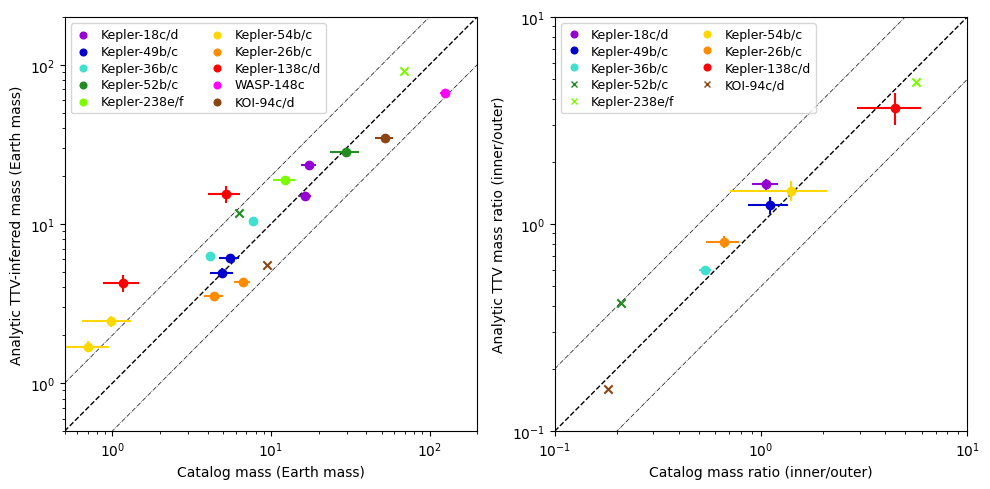

In [81]:
# PART 1 -- MASS VS MASS (prep)
inner = df2[['pl_mass_inner','pl_mass_inner_err','pl_mass_calc_inner',
             'pl_mass_calc_inner_err','Pttv_deviation_outer','fap_outer','name_inner']].copy()
outer = df2[['pl_mass_outer','pl_mass_outer_err','pl_mass_calc_outer',
             'pl_mass_calc_outer_err','Pttv_deviation_inner','fap_inner','name_inner']].copy()

inner.columns = ['x','xerr','y','yerr','c','fap','name']
outer.columns = ['x','xerr','y','yerr','c','fap','name']
allp = pd.concat([inner, outer], ignore_index=True)

m = allp['fap'] < 1e-3

x_m, xerr_m = allp.loc[m, 'x'].to_numpy(), allp.loc[m, 'xerr'].to_numpy()
y_m, yerr_m = allp.loc[m, 'y'].to_numpy(), allp.loc[m, 'yerr'].to_numpy()
x_nm, xerr_nm = allp.loc[~m, 'x'].to_numpy(), allp.loc[~m, 'xerr'].to_numpy()
y_nm, yerr_nm = allp.loc[~m, 'y'].to_numpy(), allp.loc[~m, 'yerr'].to_numpy()

name_inner = df2['name_inner'].dropna().astype(str).unique().tolist()
name_mask_m  = [(allp.loc[m,  'name'] == n).to_numpy() for n in name_inner]
name_mask_nm = [(allp.loc[~m, 'name'] == n).to_numpy() for n in name_inner]

str_outer1 = [
    string.ascii_lowercase[string.ascii_lowercase.index(s[-1]) + 1]
    if s and s[-1].islower() and s[-1] != 'z' else s
    for s in name_inner
]
colors1 = ["darkviolet", "mediumblue", "turquoise", "forestgreen", "lawngreen",
           "gold", "darkorange", "red", "fuchsia", "saddlebrown"]


# PART 2 -- MASS RATIO VS MASS RATIO (prep)
sys = df2[['name_inner',
           'pl_mass_inner','pl_mass_outer',
           'pl_mass_inner_err','pl_mass_outer_err',
           'pl_mass_calc_inner','pl_mass_calc_outer',
           'pl_mass_calc_inner_err','pl_mass_calc_outer_err',
           'fap_inner','fap_outer']].dropna().copy()

xr = (sys['pl_mass_inner'] / sys['pl_mass_outer']).to_numpy()
yr = (sys['pl_mass_calc_inner'] / sys['pl_mass_calc_outer']).to_numpy()

xr_err = xr * np.sqrt(
    (sys['pl_mass_inner_err'] / sys['pl_mass_inner'])**2 +
    (sys['pl_mass_outer_err'] / sys['pl_mass_outer'])**2
).to_numpy()

yr_err = yr * np.sqrt(
    (sys['pl_mass_calc_inner_err'] / sys['pl_mass_calc_inner'])**2 +
    (sys['pl_mass_calc_outer_err'] / sys['pl_mass_calc_outer'])**2
).to_numpy()

m_high = (
    (sys['fap_inner'] > 1e-3) |
    ((sys['fap_outer'] > 1e-3) & (sys['name_inner'] != "WASP-148 b"))
)
m_low  = ~m_high

name_sys = sys['name_inner'].astype(str).unique().tolist()
name_mask_low  = [(sys.loc[m_low,  'name_inner'] == n).to_numpy() for n in name_sys]
name_mask_high = [(sys.loc[m_high, 'name_inner'] == n).to_numpy() for n in name_sys]

str_outer2 = [
    string.ascii_lowercase[string.ascii_lowercase.index(s[-1]) + 1]
    if s and s[-1].islower() and s[-1] != 'z' else s
    for s in name_sys
]
colors2 = ["darkviolet", "mediumblue", "turquoise", "forestgreen", "lawngreen",
           "gold", "darkorange", "red", "saddlebrown"]


# PLOT (1 row, 2 cols)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# --- Subplot 1: Mass vs Mass
xlim1, ylim1 = [np.array([0.5, 200])] * 2
for i, name in enumerate(name_inner):
    col = colors1[i]
    label = f'{name}/{str_outer1[i]}' if name != 'WASP-148b' else 'WASP-148c'
    ax1.scatter(x_m[name_mask_m[i]],  y_m[name_mask_m[i]],  c=col, zorder=0, label=label)
    ax1.scatter(x_nm[name_mask_nm[i]], y_nm[name_mask_nm[i]], c=col, zorder=0, marker='x')
    ax1.errorbar(x_m[name_mask_m[i]], y_m[name_mask_m[i]],
                 xerr=xerr_m[name_mask_m[i]], yerr=yerr_m[name_mask_m[i]],
                 fmt="none", c=col, zorder=-1)

ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("Catalog mass (Earth mass)")
ax1.set_ylabel("Analytic TTV-inferred mass (Earth mass)")
ax1.set_xlim(xlim1); ax1.set_ylim(ylim1)
ax1.plot(xlim1, ylim1,   ls="--", color='black', lw=1.0, zorder=-2)
ax1.plot(xlim1, ylim1*2, ls="-.", color='black', lw=0.5, zorder=-2)
ax1.plot(xlim1, ylim1/2, ls="-.", color='black', lw=0.5, zorder=-2)
ax1.legend(ncol=2, fontsize=9, markerscale=0.8, handlelength=1.2, labelspacing=0.3)

# --- Subplot 2: Mass ratio vs Mass ratio
xlim2, ylim2 = [np.array([1e-1, 1e1])] * 2

handles, labels = [], []
for i, name in enumerate(name_sys):
    col = colors2[i]
    label = f'{name}/{str_outer2[i]}'

    # Plot low-FAP (o)
    ax2.scatter(xr[m_low][name_mask_low[i]],  yr[m_low][name_mask_low[i]],
                c=col, zorder=0)
    ax2.errorbar(xr[m_low][name_mask_low[i]], yr[m_low][name_mask_low[i]],
                 xerr=xr_err[m_low][name_mask_low[i]],
                 yerr=yr_err[m_low][name_mask_low[i]],
                 fmt="none", c=col, zorder=-1)

    # Plot high-FAP (x)
    ax2.scatter(xr[m_high][name_mask_high[i]], yr[m_high][name_mask_high[i]],
                c=col, zorder=0, marker='x')
    # ax2.errorbar(xr[m_high][name_mask_high[i]], yr[m_high][name_mask_high[i]],
    #              xerr=xr_err[m_high][name_mask_high[i]],
    #              yerr=yr_err[m_high][name_mask_high[i]],
    #              fmt="none", c='lightgrey', zorder=-1)

    # Legend handle: x if this system has any high-FAP, else o
    is_high = ((sys['name_inner'] == name) &
               ((sys['fap_inner'] > 1e-3) | (sys['fap_outer'] > 1e-3))).any()
    marker = 'x' if is_high else 'o'
    handles.append(Line2D([], [], color=col, marker=marker, linestyle='None', label=label))
    labels.append(label)

ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("Catalog mass ratio (inner/outer)")
ax2.set_ylabel("Analytic TTV mass ratio (inner/outer)")
ax2.set_xlim(xlim2); ax2.set_ylim(ylim2)
ax2.plot(xlim2, ylim2,   ls="--", color='black', lw=1.0, zorder=-2)
ax2.plot(xlim2, ylim2*2, ls="-.", color='black', lw=0.5, zorder=-2)
ax2.plot(xlim2, ylim2/2, ls="-.", color='black', lw=0.5, zorder=-2)
ax2.legend(handles, labels, ncol=2, fontsize=9, markerscale=0.8,
           handlelength=1.2, labelspacing=0.3)

plt.tight_layout()
plt.show()